# LSTM Regressor

Autoregression and predict one day ahead

The main idea to train and test the model is shown as follows:
1. Split the training set and test set
2. Use the cross validation method to find the optimal combination of hyperparameters
3. Use the model to predict the data
4. Data visualization

Import library needed in the model

In [1]:
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Split the training set and test set
(Use the dataset whose outliers are deleted)

In [2]:
df=pd.read_csv('../dataset_for_analysis/data_weather_new1.csv',parse_dates=['date'])
df.set_index('date', inplace=True)

# Select the data used for model training
start_date='2000-01-01'
end_date='2020-12-31'
training_data=df[start_date:end_date]

X_mean_temp=training_data[['mean_temp','min_temp']]

In [3]:
X_mean_temp

,mean_temp,min_temp
date,,
2000-01-01,7.0,4.9
2000-01-02,7.9,5.0
2000-01-03,9.4,7.2
2000-01-04,7.0,4.4
2000-01-05,6.4,1.9
...,...,...
2020-12-27,7.5,7.6
2020-12-28,1.1,-1.3
2020-12-29,2.6,1.1


Scaling the data

In [5]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler(feature_range=(-1,1))
scaled_mean_temp=scalar.fit_transform(X_mean_temp)

In [6]:
scaled_mean_temp[:5]

array([[-0.32110092, -0.24285714],
       [-0.26605505, -0.23571429],
       [-0.17431193, -0.07857143],
       [-0.32110092, -0.27857143],
       [-0.35779817, -0.45714286]])

In [7]:
timestep=30
X=[]
Y=[]
for i in range(len(X_mean_temp)-timestep):
    X.append(scaled_mean_temp[i:i+timestep])
    Y.append(scaled_mean_temp[i+timestep])

In [8]:
X=np.asanyarray(X)

In [9]:
Y=np.asanyarray(Y)

In [10]:
k1 = 6910
k2 = 7275
Xtrain = X[:k1,:,:]
Xtest = X[k1:k2,:,:]
X2020 = X[k2:,:,:]
Ytrain = Y[:k1]
Ytest= Y[k1:k2]
Y2020 = Y[k2:]

In [11]:
Xtrain.shape

(6910, 30, 2)

In [12]:
Xtest.shape

(365, 30, 2)

In [13]:
X2020.shape

(366, 30, 2)

## Single output (predict one day ahead)

Create the instance of tensorboard to visualize the results

In [14]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir="../lstm_results/logs")

In [15]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,2)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')

Fit and the model to predict the mean_temp

In [16]:
history = model.fit(Xtrain,Ytrain,validation_data=(Xtest,Ytest), epochs=10, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/10
216/216 [==============================] - 27s 90ms/step - loss: 0.0303 - val_loss: 0.0212
Epoch 2/10
216/216 [==============================] - 18s 83ms/step - loss: 0.0220 - val_loss: 0.0202
Epoch 3/10
216/216 [==============================] - 18s 81ms/step - loss: 0.0199 - val_loss: 0.0205
Epoch 4/10
216/216 [==============================] - 18s 81ms/step - loss: 0.0191 - val_loss: 0.0202
Epoch 5/10
216/216 [==============================] - 17s 81ms/step - loss: 0.0184 - val_loss: 0.0194
Epoch 6/10
216/216 [==============================] - 18s 82ms/step - loss: 0.0179 - val_loss: 0.0200
Epoch 7/10
216/216 [==============================] - 17s 78ms/step - loss: 0.0179 - val_loss: 0.0201
Epoch 8/10
216/216 [==============================] - 17s 80ms/step - loss: 0.0174 - val_loss: 0.0196
Epoch 9/10
216/216 [==============================] - 18s 82ms/step - loss: 0.0172 - val_loss: 0.0197
Epoch 10/10
216/216 [==============================] - 18s 82ms/step - loss: 0.016

In [17]:
model.save('../lstm_results/lstm_regressor.hdf5')

In [18]:
from tensorflow.keras.models import load_model
model=load_model('../lstm_results/lstm_regressor.hdf5')

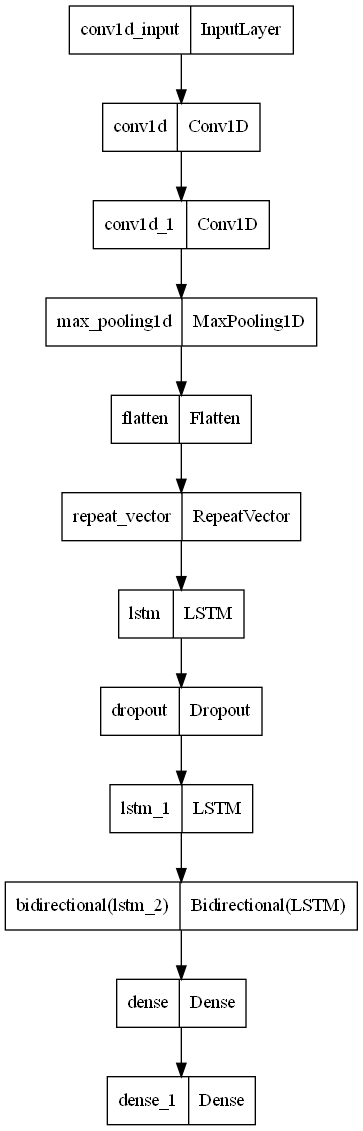

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Module evaluation and results visualizaiton

In [20]:
from tensorflow.keras.models import load_model
model=load_model('../lstm_results/lstm_regressor.hdf5')

In [21]:
predicted_result=model.predict(X2020)

12/12 [==============================] - 1s 27ms/step


In [22]:
predicted_result=scalar.inverse_transform(predicted_result)
predicted_result

array([[ 5.3612766 ,  2.5301967 ],
       [ 2.6816905 , -0.12906142],
       [ 5.785376  ,  2.8757215 ],
       [ 7.8682446 ,  6.1257925 ],
       [ 3.5447502 ,  0.8370496 ],
       [ 6.5023627 ,  3.8646095 ],
       [ 5.9327755 ,  3.4777975 ],
       [ 6.188241  ,  3.6243691 ],
       [ 8.354386  ,  6.6501036 ],
       [ 7.817516  ,  6.0406337 ],
       [ 5.2456136 ,  2.5707088 ],
       [ 5.864495  ,  3.2728577 ],
       [ 8.142865  ,  6.045287  ],
       [ 5.689591  ,  3.1808128 ],
       [ 8.258534  ,  6.133753  ],
       [ 6.4145393 ,  4.031673  ],
       [ 7.042704  ,  4.5742335 ],
       [ 7.4607854 ,  5.6192627 ],
       [ 2.7752187 ,  0.27176803],
       [ 2.7302175 , -0.06606849],
       [ 2.9151697 ,  0.17789988],
       [ 2.0505683 , -0.9141328 ],
       [ 2.7268076 , -0.08337863],
       [ 4.3796735 ,  1.8863931 ],
       [ 3.7239392 ,  1.2251294 ],
       [ 4.0355887 ,  1.4978709 ],
       [ 5.2406096 ,  2.9155397 ],
       [ 5.9033093 ,  3.4101875 ],
       [ 3.4891481 ,

In [23]:
actual_ytest=scalar.inverse_transform(Y2020)
actual_ytest

array([[ 4.1,  1.7],
       [ 8.6,  6.2],
       [ 9.9,  9.4],
       [ 5.6,  2.2],
       [ 7.8,  6.5],
       [ 7.8,  6.6],
       [ 8.1,  4.1],
       [11.8, 11.6],
       [11.5,  9.6],
       [ 7.1,  5.7],
       [ 8. ,  5. ],
       [10.6,  9.6],
       [ 7.5,  4.6],
       [10.3,  7.2],
       [ 9.1,  8. ],
       [ 8.9,  5.2],
       [ 8.5,  7.4],
       [ 4.6,  1.2],
       [ 3.7, -0.3],
       [ 4.3, -0.3],
       [ 3. , -2. ],
       [ 4.3,  0.6],
       [ 7.6,  7.1],
       [ 6.5,  6. ],
       [ 6.3,  5.6],
       [ 8.1,  5.7],
       [ 8.5,  7.5],
       [ 5.4,  2.6],
       [ 6. ,  2.4],
       [10. ,  7. ],
       [10.7,  8.6],
       [11.2, 10. ],
       [ 9.9,  6.4],
       [10.3,  8.5],
       [ 6.7,  4. ],
       [ 6. ,  2.4],
       [ 4.8,  0. ],
       [ 5. ,  0.7],
       [ 9.5,  7.9],
       [10.4,  7.6],
       [ 7.5,  5.4],
       [ 6. ,  3.5],
       [ 5.6,  2.2],
       [ 8. ,  5.6],
       [ 7.2,  1.9],
       [11.4,  9.9],
       [12.5, 12. ],
       [ 8.4,

In [24]:
predicted_mean_temp=predicted_result[:,0]
predicted_precipitation=predicted_result[:,1]

In [25]:
actual_mean_temp=actual_ytest[:,0]
actual_precipitation=actual_ytest[:,1]

In [26]:
from sklearn.metrics import mean_squared_error
error_mean_temp=mean_squared_error(actual_mean_temp, predicted_mean_temp)
error_precipitation=mean_squared_error(actual_precipitation, predicted_precipitation)
print("MSE for mean_temp prediction: ", error_mean_temp)
print("MSE for precipitation prediction: ", error_precipitation)

MSE for mean_temp prediction:  6.8733135612354985
MSE for precipitation prediction:  7.899143081639173


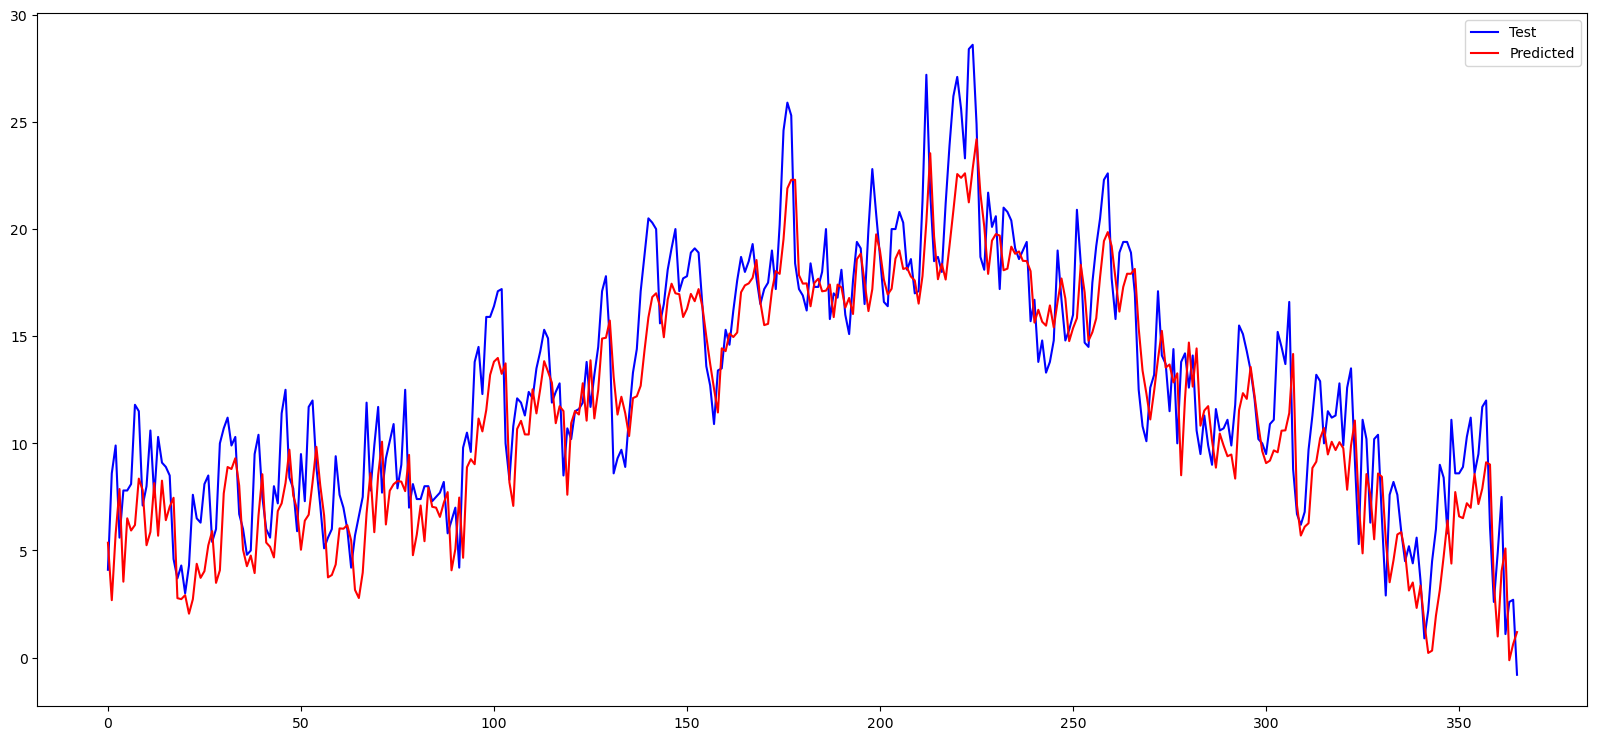

In [27]:
plt.figure(figsize=(20,9))
plt.plot(actual_mean_temp , 'blue')
plt.plot(predicted_mean_temp,'r')
plt.legend(('Test','Predicted'))
plt.show()

## Multiple output (predict one week ahead)